In [1]:
pip install trdg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4019 sha256=b74f1f0abf2796fc80e65ed5392b61c41cf606ba5f6265cea3272eaccc6db221
  Stored in directory: /root/.cache/pip/wheels/90/57/92/d4259a51f20cf92a473b567a009674e3390852b7fab19be6dc
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=1315f5f54f176abd93179c63e844a95e7ad409b1b560ed43bac0edc8588523e0
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built diffimg wikipedia


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/OCR_proj/trdg"

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/OCR_proj/trdg'
/content


In [20]:
from trdg.generators import GeneratorFromStrings
from PIL import Image
import os
import csv
import random
import string

# Define output directory and CSV file path
output_dir = "ocr_dataset4"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "labels.csv")

# Function to generate random words
def generate_random_word(length=10):
    letters = string.ascii_lowercase + ' '
    return ''.join(random.choice(letters) for i in range(length))

# Function to save images with labels
def save_handwritten_text_images(output_dir, csv_file, num_samples=10):
    # Generate random words
    random_words = [generate_random_word(10) for _ in range(num_samples)]

    # Create generator for handwritten text
    generator = GeneratorFromStrings(
        random_words,
        blur=0,  # No blur
        random_blur=False,
        distorsion_type=0,  # No distortion
        size=32,  # Font size
        language="en"  # Language set to English
    )

    labels = []
    fixed_width = 256
    fixed_height = 56

    for count, (img, lbl) in enumerate(generator):
        if count >= num_samples:
            break
        img = img.convert("L")  # Convert image to grayscale
        # Resize the image to fixed dimensions
        img = img.resize((fixed_width, fixed_height), Image.ANTIALIAS)
        # Save image with related filename
        img_filename = os.path.join(output_dir, f"{count+1}.png")
        img.save(img_filename)
        print(f"Saved {img_filename} with label {lbl}")
        labels.append(lbl)

    # Save labels to CSV
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Label"])
        for label in labels:
            writer.writerow([label])

# Generate and save images
num_samples = 100 ## USER 20 000
save_handwritten_text_images(output_dir, csv_file, num_samples=num_samples)

Saved ocr_dataset4/1.png with label zrjuooalui
Saved ocr_dataset4/2.png with label fjktgnjgjs
Saved ocr_dataset4/3.png with label eeh uzpmdc
Saved ocr_dataset4/4.png with label vktjhoqmda
Saved ocr_dataset4/5.png with label isqptaktht
Saved ocr_dataset4/6.png with label dksoknhhhu
Saved ocr_dataset4/7.png with label csahuzfkzb
Saved ocr_dataset4/8.png with label dvejfnenke
Saved ocr_dataset4/9.png with label  hmcdlqoxf
Saved ocr_dataset4/10.png with label cjcdxlfnrs
Saved ocr_dataset4/11.png with label iervonwvl 
Saved ocr_dataset4/12.png with label yo gfhcboy
Saved ocr_dataset4/13.png with label vmhirb tnc
Saved ocr_dataset4/14.png with label issvywifbk
Saved ocr_dataset4/15.png with label sn lkfcmuu
Saved ocr_dataset4/16.png with label  qjqxdcbms
Saved ocr_dataset4/17.png with label leekxcbqrz
Saved ocr_dataset4/18.png with label qlmgyobywc
Saved ocr_dataset4/19.png with label dmuahmdvtb
Saved ocr_dataset4/20.png with label mojpatarsl
Saved ocr_dataset4/21.png with label mfoynxevxb
S

abcdefghijklmnopqrstuvwxyz 


torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


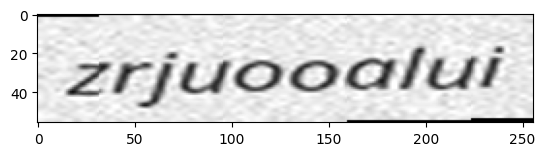

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


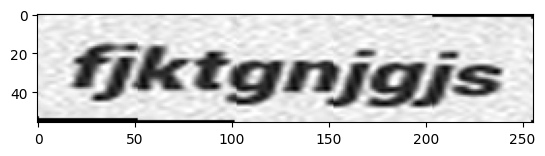

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


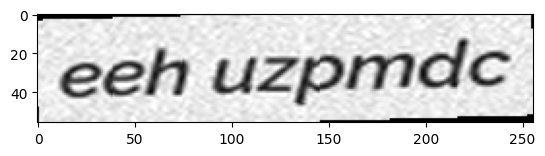

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


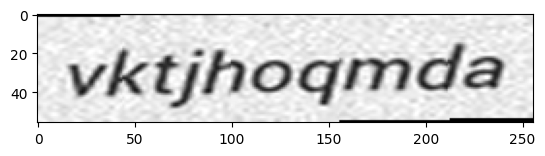

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


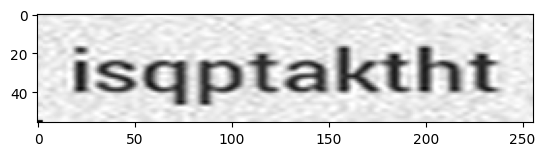

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


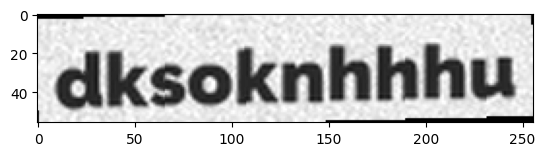

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


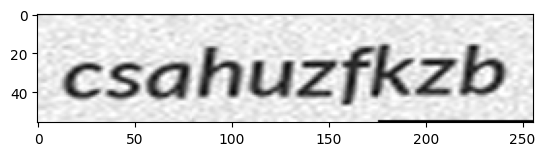

torch.Size([1, 56, 256])
tensor(0.4706) tensor(1.)


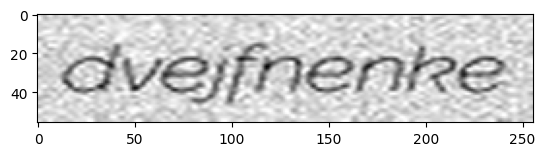

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


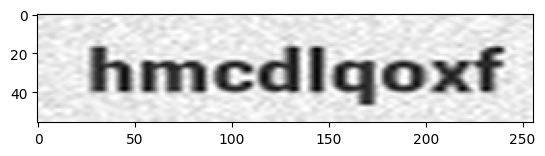

torch.Size([1, 56, 256])
tensor(0.) tensor(1.)


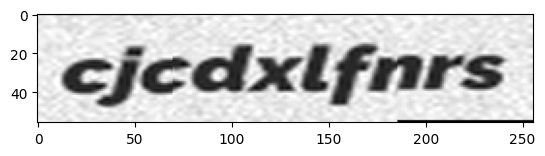

In [36]:
# apply corruptions to the preprocess
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

num_samples = 100

# 0 : rotation
# 1 : affine tsf
# 2 Gaussian blur

## USER
tsf = 0
p = 0.1 # intensity of corruption
##

float_to_odd_number = lambda float_value: (lambda n: n if n % 2 != 0 else n + 1 if n < float_value else n - 1)(int(round(float_value)))

corr_list = [transforms.RandomRotation(degrees=p*20), transforms.RandomAffine(degrees=p*20), transforms.GaussianBlur(float_to_odd_number(p*20))]


# compose transformations including the specified corruption
transform = transforms.Compose([
                                 corr_list[tsf],
                                 transforms.ToTensor()
                                ])

names = [str(x) + '.png' for x in range(1, num_samples+1)]
paths = [os.path.join(output_dir, name) for name in names]
images = []

for path in paths:
  img = Image.open(path)
  # Data Augmentation using transforms
  images.append(transform(img))

# for image in images[:10]:
#   print(image.shape)
#   print(torch.min(image), torch.max(image))
#   plt.imshow(image.permute(1, 2, 0), cmap='gray')
#   plt.show()

In [ ]:
# data loader

